In [11]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
warnings.filterwarnings("ignore")

In [12]:
# Pfade zu den Dateien (Dateien müssen im gleichen Ordner liegen oder Pfad anpassen)
users_df = pd.read_csv("users.csv")
answers_df = pd.read_csv("answers.csv")

# Antworten mit Gruppenzugehörigkeit mergen
merged_df = answers_df.merge(users_df, left_on="user_id", right_on="id")

In [13]:
# Gruppierung nach Gruppen und Berechnung des Mittelwertes, Standardabweichung und Anzahl der gesamten Bewertungen pro Gruppe
group_stats = merged_df.groupby("gruppe")["credibility_rating"].agg(["mean", "std", "count"])
print("Deskriptive Statistik pro Gruppe:\n")
print(group_stats)

Deskriptive Statistik pro Gruppe:

            mean       std  count
gruppe                           
0       4.679487  1.963919     78
1       5.194444  1.741287     72
2       4.469697  1.756042     66


In [14]:
# Überprüfung, ob Werte Normalverteilt sind
print("\nShapiro-Wilk-Test pro Gruppe:")
for group in merged_df["gruppe"].unique():
    ratings = merged_df[merged_df["gruppe"] == group]["credibility_rating"]
    stat, p = stats.shapiro(ratings)
    print(f"Gruppe {group}: p-Wert = {p:.5f} {'(nicht normalverteilt)' if p < 0.05 else '(normalverteilt)'}")


Shapiro-Wilk-Test pro Gruppe:
Gruppe 0: p-Wert = 0.00000 (nicht normalverteilt)
Gruppe 1: p-Wert = 0.00000 (nicht normalverteilt)
Gruppe 2: p-Wert = 0.00148 (nicht normalverteilt)


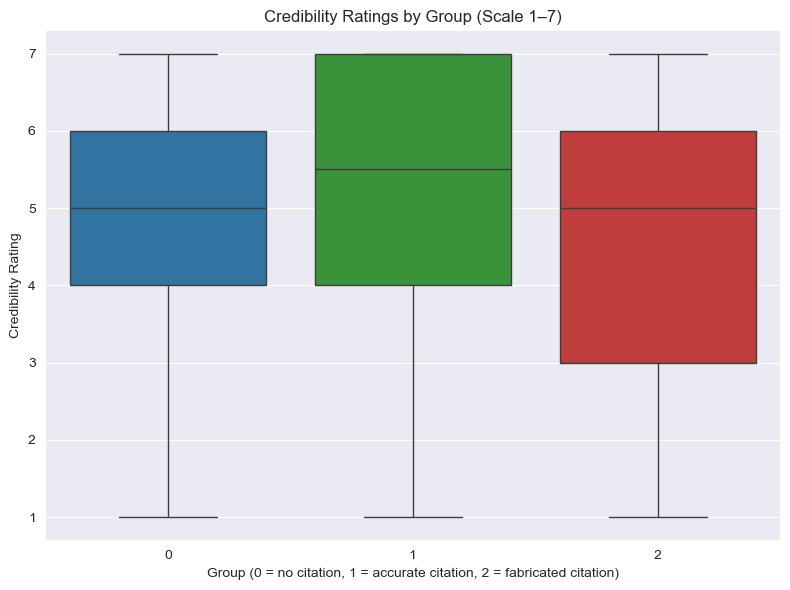

In [15]:
# Boxplot der Daten zur Visualisierung
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="gruppe",
    y="credibility_rating",
    data=merged_df,
    palette={"0": "#1f77b4", "1": "#2ca02c", "2": "#d62728"}  # Blau, Grün, Rot
)
plt.title("Credibility Ratings by Group (Scale 1–7)")
plt.xlabel("Group (0 = no citation, 1 = accurate citation, 2 = fabricated citation)")
plt.ylabel("Credibility Rating")
plt.tight_layout()
plt.savefig(fname="boxplot.png")
plt.show()

In [16]:
# Da > 2 Gruppen nicht normalverteilt -> Kruskal-Wallis-Test
# Alle Credibility Werte für jede eindeutige Gruppe holen
grouped_ratings = [merged_df[merged_df["gruppe"] == g]["credibility_rating"] for g in merged_df["gruppe"].unique()]
# Test durchführen
kw_result = stats.kruskal(*grouped_ratings)
print(f"\nKruskal-Wallis-Test: H = {kw_result.statistic:.3f}, p-Wert = {kw_result.pvalue:.5f}")



Kruskal-Wallis-Test: H = 6.935, p-Wert = 0.03119


In [17]:
#Post-hoc Mann-Whitney-U-Tests mit Bonferroni-Korrektur
pairwise_tests = []
groups = merged_df["gruppe"].unique()

# Gruppenvergleich
for g1, g2 in combinations(groups, 2):
    # Credibility Werte aus beiden Gruppen holen
    d1 = merged_df[merged_df["gruppe"] == g1]["credibility_rating"]
    d2 = merged_df[merged_df["gruppe"] == g2]["credibility_rating"]
    # Mann-Whitney-U-Test
    stat, p = stats.mannwhitneyu(d1, d2, alternative="two-sided")
    # Ergebnisse speichern
    pairwise_tests.append({
        "Vergleich": f"{g1} vs. {g2}",
        "U-Statistik": stat,
        "p-Wert": p
    })

# In DataFrame umwandeln
posthoc_df = pd.DataFrame(pairwise_tests)
# Verschärfung des p-Wertes, um Risiko für zufällige Signifikanzen zu senken
posthoc_df["Bonferroni-korrigierter p-Wert"] = np.minimum(posthoc_df["p-Wert"] * len(posthoc_df), 1.0)

print("\nPost-hoc Mann-Whitney-U-Tests (Bonferroni-korrigiert):")
print(posthoc_df)


Post-hoc Mann-Whitney-U-Tests (Bonferroni-korrigiert):
  Vergleich  U-Statistik    p-Wert  Bonferroni-korrigierter p-Wert
0   0 vs. 1       2375.0  0.097059                        0.291178
1   0 vs. 2       2827.0  0.303710                        0.911130
2   1 vs. 2       2974.5  0.009502                        0.028507


In [18]:
answers = pd.read_csv('answers.csv')
users = pd.read_csv('users.csv')


# Antworten der User mit Bewertung in Json pro Gruppe speichern
merged_df = answers.merge(users, left_on='user_id', right_on='id', how='inner')

gruppen = {gruppe: df for gruppe, df in merged_df.groupby('gruppe')}

gruppe_0 = gruppen.get(0)
gruppe_1 = gruppen.get(1)
gruppe_2 = gruppen.get(2)

gruppe_0_data = [(row['question_text'], row['credibility_rating'], row['answer_text']) for _, row in gruppe_0.iterrows() if not pd.isna(row['answer_text'])]
gruppe_1_data = [(row['question_text'], row['credibility_rating'], row['answer_text']) for _, row in gruppe_1.iterrows() if not pd.isna(row['answer_text'])]
gruppe_2_data = [(row['question_text'], row['credibility_rating'], row['answer_text']) for _, row in gruppe_2.iterrows() if not pd.isna(row['answer_text'])]


# Json speichern
with open('gruppe_0_data.json', 'w', encoding='utf-8') as f:
    json.dump(gruppe_0_data, f, ensure_ascii=False, indent=4)

with open('gruppe_1_data.json', 'w', encoding='utf-8') as f:
    json.dump(gruppe_1_data, f, ensure_ascii=False, indent=4)

with open('gruppe_2_data.json', 'w', encoding='utf-8') as f:
    json.dump(gruppe_2_data, f, ensure_ascii=False, indent=4)

In [19]:
def lade_json(pfad):
    with open(pfad, 'r', encoding='utf-8') as f:
        return json.load(f)

def flatten_liste(liste):
    if len(liste) == 1 and isinstance(liste[0], list):
        return liste[0]
    return liste

# Schlagworte, die auf quellenbezogene Aussagen hindeuten
quellen_schlagworte = [
    "quelle", "belegt", "link", "beweis",
]


# Match mit Schlagwörtern überprüfen
def ist_quellenbezogen(text):
    if not isinstance(text, str):
        return False
    text = text.lower()
    return any(wort in text for wort in quellen_schlagworte)

# Einträge Speichern
def verarbeite_eintraege(eintraege, gruppenname):
    verarbeitete = []
    for eintrag in eintraege:
        kommentar = ""
        if isinstance(eintrag, dict):
            kommentar = eintrag.get("Kommentar", "")
            if ist_quellenbezogen(kommentar):
                verarbeitete.append({
                    "Gruppe": gruppenname,
                    "Frage": eintrag.get("Frage", ""),
                    "Bewertung": eintrag.get("Bewertung", ""),
                    "Kommentar": kommentar,
                })
        elif isinstance(eintrag, list) and len(eintrag) >= 3:
            kommentar = eintrag[2]
            if ist_quellenbezogen(kommentar):
                verarbeitete.append({
                    "Gruppe": gruppenname,
                    "Frage": eintrag[0],
                    "Bewertung": eintrag[1],
                    "Kommentar": kommentar,
                })
        else:
            print(f"⚠️ Ungültiger Eintrag ignoriert: {eintrag}")
    return verarbeitete

# Daten laden und verarbeiten
gruppe_0 = flatten_liste(lade_json('gruppe_0_data.json'))
gruppe_1 = flatten_liste(lade_json('gruppe_1_data.json'))
gruppe_2 = flatten_liste(lade_json('gruppe_2_data.json'))

gruppe_0 = verarbeite_eintraege(gruppe_0, "gruppe_0")
gruppe_1 = verarbeite_eintraege(gruppe_1, "gruppe_1")
gruppe_2 = verarbeite_eintraege(gruppe_2, "gruppe_2")

# Zusammenführen
zielstruktur = gruppe_0 + gruppe_1 + gruppe_2

# Speichern
with open('quellenbezogenen_kommentaren.json', 'w', encoding='utf-8') as f:
    json.dump(zielstruktur, f, indent=2, ensure_ascii=False)

print(f"{len(zielstruktur)} quellenbezogene Kommentare gespeichert in")


31 quellenbezogene Kommentare gespeichert in
